## Importing the libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
training_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp/train.csv")

In [5]:
training_data

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [6]:
Bitcoin = training_data.loc[training_data['Asset_ID'] == 1].set_index("timestamp")

btc_mini = Bitcoin.iloc[-200:]

## Visualizing the data

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

## Pre-processing the data

In [8]:
def make_dataset(data, window):
  samples = []
  labels = []
  for i in range(window-1, len(data)):
    samples.append(data[i-(window-1):i])
    labels.append(data[i])
  return samples, labels

In [9]:
features, labels = make_dataset(list(Bitcoin['VWAP']), 101)

In [10]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(features)

In [11]:
def mini_batch(features, labels, batch_size):
  batched_features = []
  batched_labels = []
  dataset_size = int(len(features)/batch_size)*batch_size
  features = features[:dataset_size]
  labels = labels[:dataset_size]
  for i in range(0, dataset_size, batch_size):
    batched_features.append(features[i:i+batch_size])
    batched_labels.append(labels[i:i+batch_size])
  return batched_features, batched_labels

In [12]:
def test_train_split(batched_features, batched_labels, test_ratio):
  train_batch_size = int(len(batched_features)*(1-test_ratio))
  training_batch_features = batched_features[:train_batch_size]
  training_batch_labels = batched_labels[:train_batch_size]
  test_batch_features = batched_features[train_batch_size:]
  test_batch_labels = batched_labels[train_batch_size:]
  return training_batch_features, training_batch_labels, test_batch_features, test_batch_labels

In [13]:
batched_features, batched_labels = mini_batch(X_btc_train_scaled, labels, 64)

training_batch_features, training_batch_labels, test_batch_features, test_batch_labels = test_train_split(batched_features, batched_labels, 0.2)

In [14]:
training_batch_features = np.array(training_batch_features)
training_batch_labels = np.array(training_batch_labels)

test_batch_features = np.array(test_batch_features)
test_batch_labels = np.array(test_batch_labels)

In [15]:
test_batch_labels.shape

(6113, 64)

## Model Architecture

In [16]:
# tf.debugging.set_log_device_placement(True)


model = tf.keras.Sequential([
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error')

In [17]:
num_epochs = 50

history = model.fit(training_batch_features, training_batch_labels, epochs=num_epochs)

Epoch 1/50
765/765 [==============================] - 59s 59ms/step - loss: 8461.6855
Epoch 2/50
765/765 [==============================] - 46s 60ms/step - loss: 7941.9331
Epoch 3/50
765/765 [==============================] - 46s 60ms/step - loss: 6435.4424
Epoch 4/50
765/765 [==============================] - 45s 59ms/step - loss: 4073.7632
Epoch 5/50
765/765 [==============================] - 45s 59ms/step - loss: 1848.6040
Epoch 6/50
765/765 [==============================] - 45s 59ms/step - loss: 844.4854
Epoch 7/50
765/765 [==============================] - 46s 60ms/step - loss: 534.6119
Epoch 8/50
765/765 [==============================] - 45s 59ms/step - loss: 426.5080
Epoch 9/50
765/765 [==============================] - 46s 60ms/step - loss: 323.4179
Epoch 10/50
765/765 [==============================] - 46s 60ms/step - loss: 270.1809
Epoch 11/50
765/765 [==============================] - 45s 59ms/step - loss: 191.6065
Epoch 12/50
765/765 [==============================] - 45s

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64, 40)           19360     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 40)           9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64, 64)            2624      
                                                                 
 dense_1 (Dense)             (None, 64, 64)            4160      
                                                                 
 dense_2 (Dense)             (None, 64, 1)             65        
                                                                 
Total params: 35,969
Trainable params: 35,969
Non-traina

In [19]:
predictions = model.predict(training_batch_features)

In [20]:
training_batch_labels[-1]

array([23470.38695302, 23483.63308286, 23474.1904778 , 23448.69685346,
       23466.31118173, 23491.6777918 , 23505.18238825, 23518.37559474,
       23528.41371732, 23541.90953099, 23564.74901316, 23570.12864168,
       23562.13482481, 23546.40943927, 23542.8228694 , 23536.0224601 ,
       23536.65769061, 23551.32468195, 23564.92973573, 23548.91846701,
       23534.93175534, 23544.84761508, 23539.4406734 , 23526.71362522,
       23526.75538564, 23525.27910655, 23522.15121003, 23500.49702625,
       23472.09770795, 23456.21603855, 23458.37118635, 23469.57566099,
       23465.32948009, 23462.37442796, 23464.10699489, 23480.54145044,
       23475.4109068 , 23469.52480968, 23472.12490904, 23491.61673744,
       23506.21335063, 23525.88053481, 23511.16734377, 23492.22126396,
       23504.11139269, 23488.73380081, 23479.98867967, 23501.38286398,
       23530.52807472, 23532.22980432, 23520.23528471, 23516.50963118,
       23529.26015252, 23558.50645534, 23576.16958401, 23581.26186388,
      

No handles with labels found to put in legend.


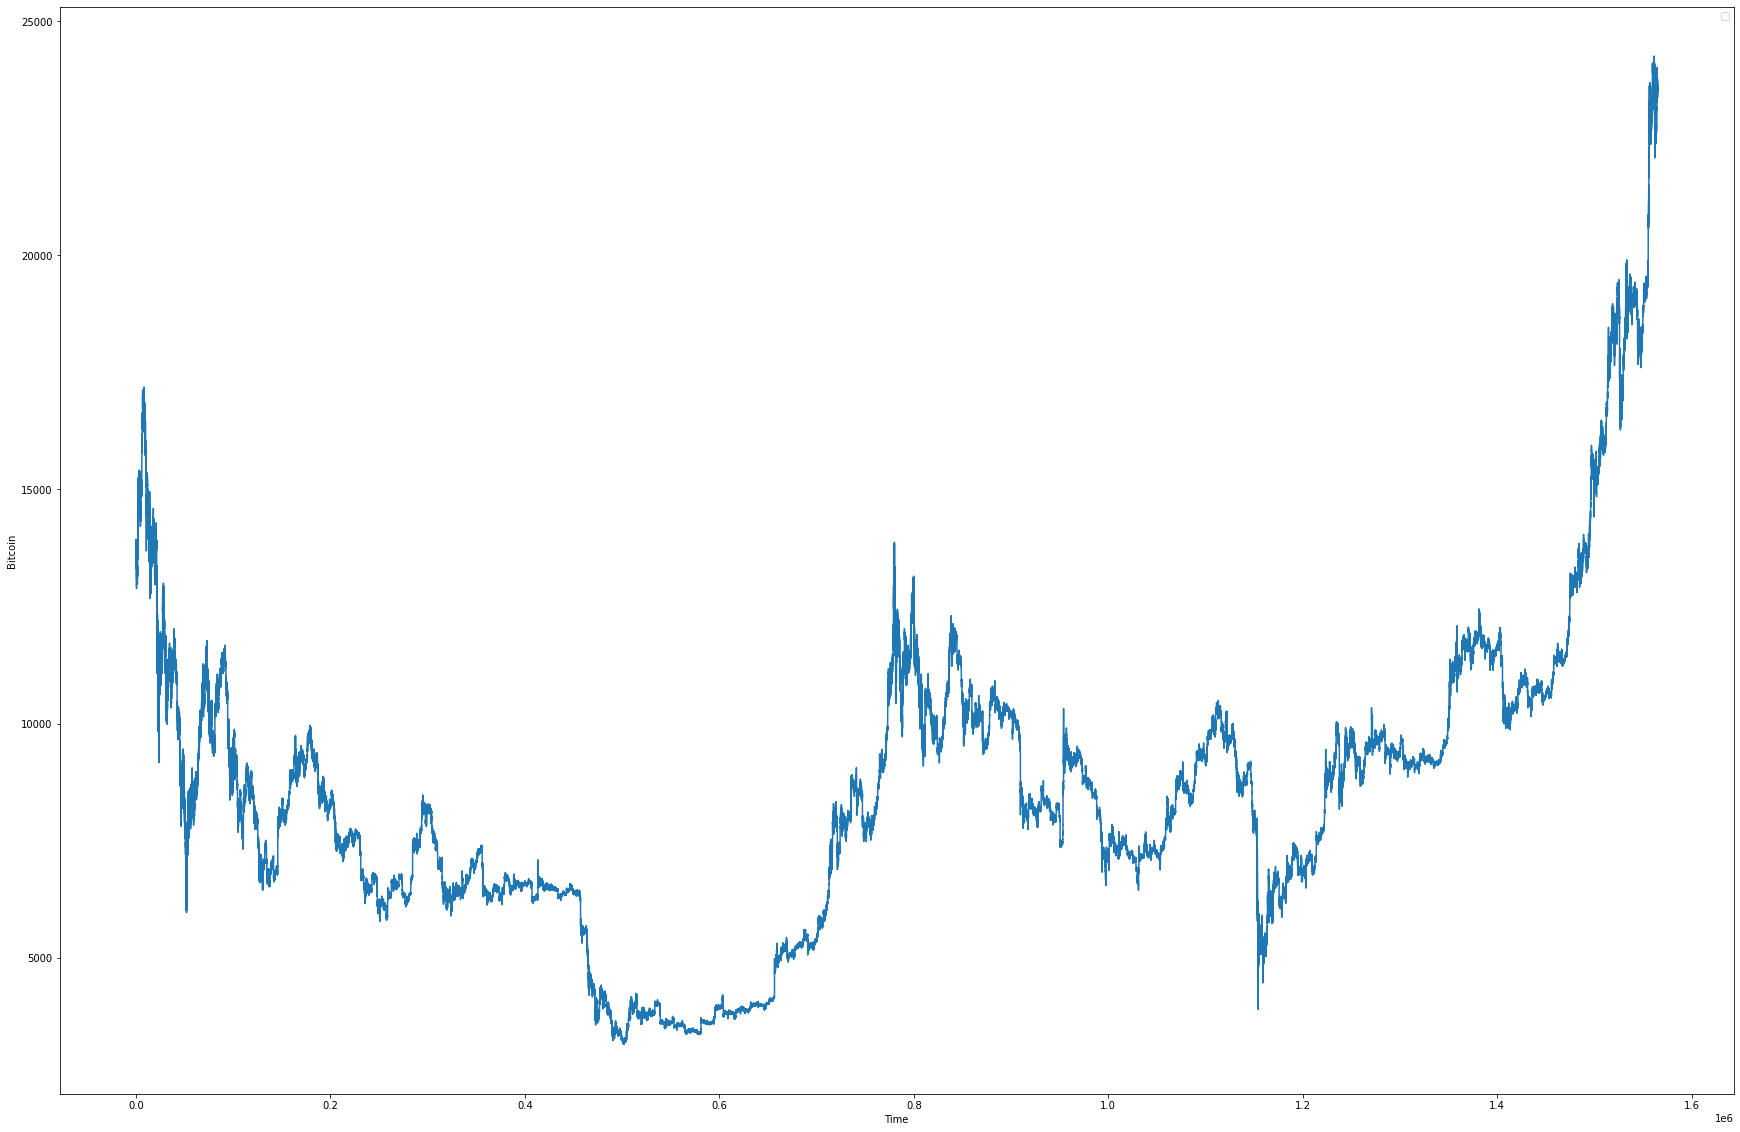

In [21]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(30,20))

plt.plot(training_batch_labels.flatten())
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')


plt.show()


No handles with labels found to put in legend.


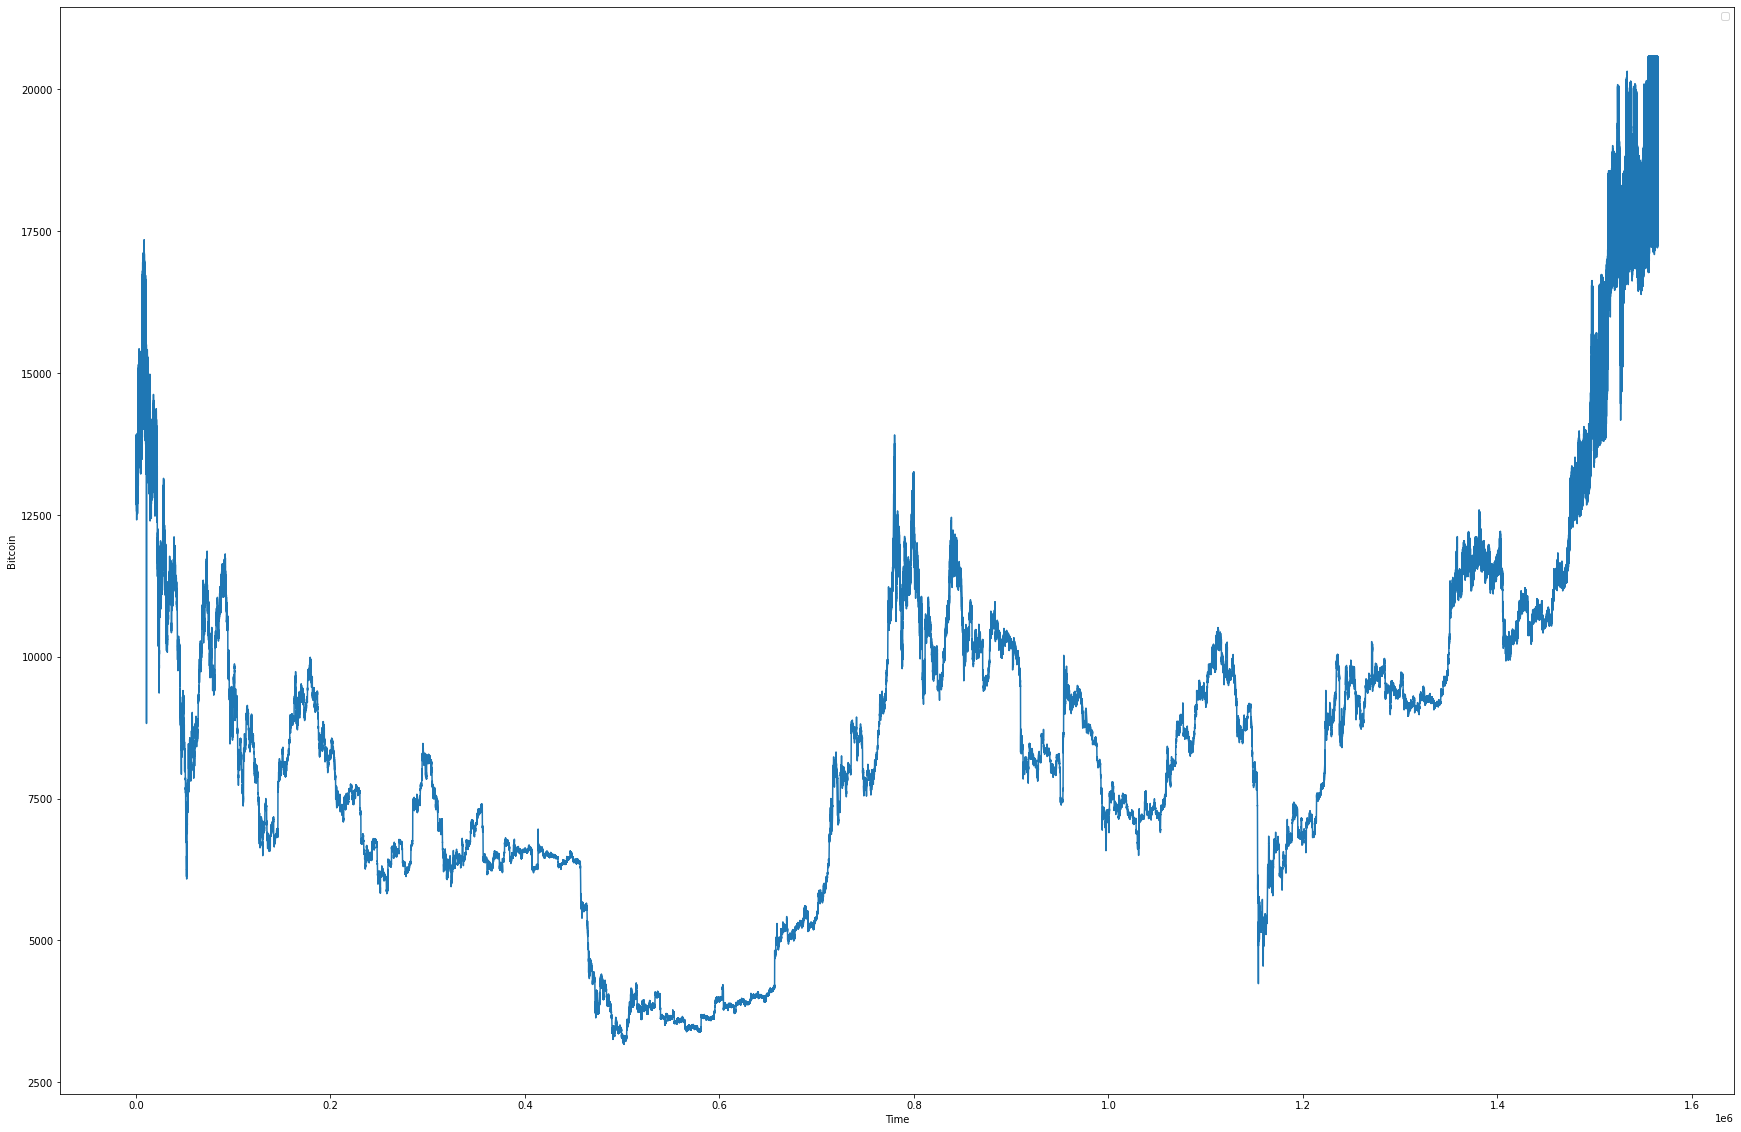

In [22]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(30,20))

plt.plot(predictions.flatten())
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')


plt.show()

In [23]:
!mkdir -p saved_model
model.save('/content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/CryptoPricePredictionApp/assets


## Testing the data

In [24]:
test_predictions = model.predict(test_batch_features)

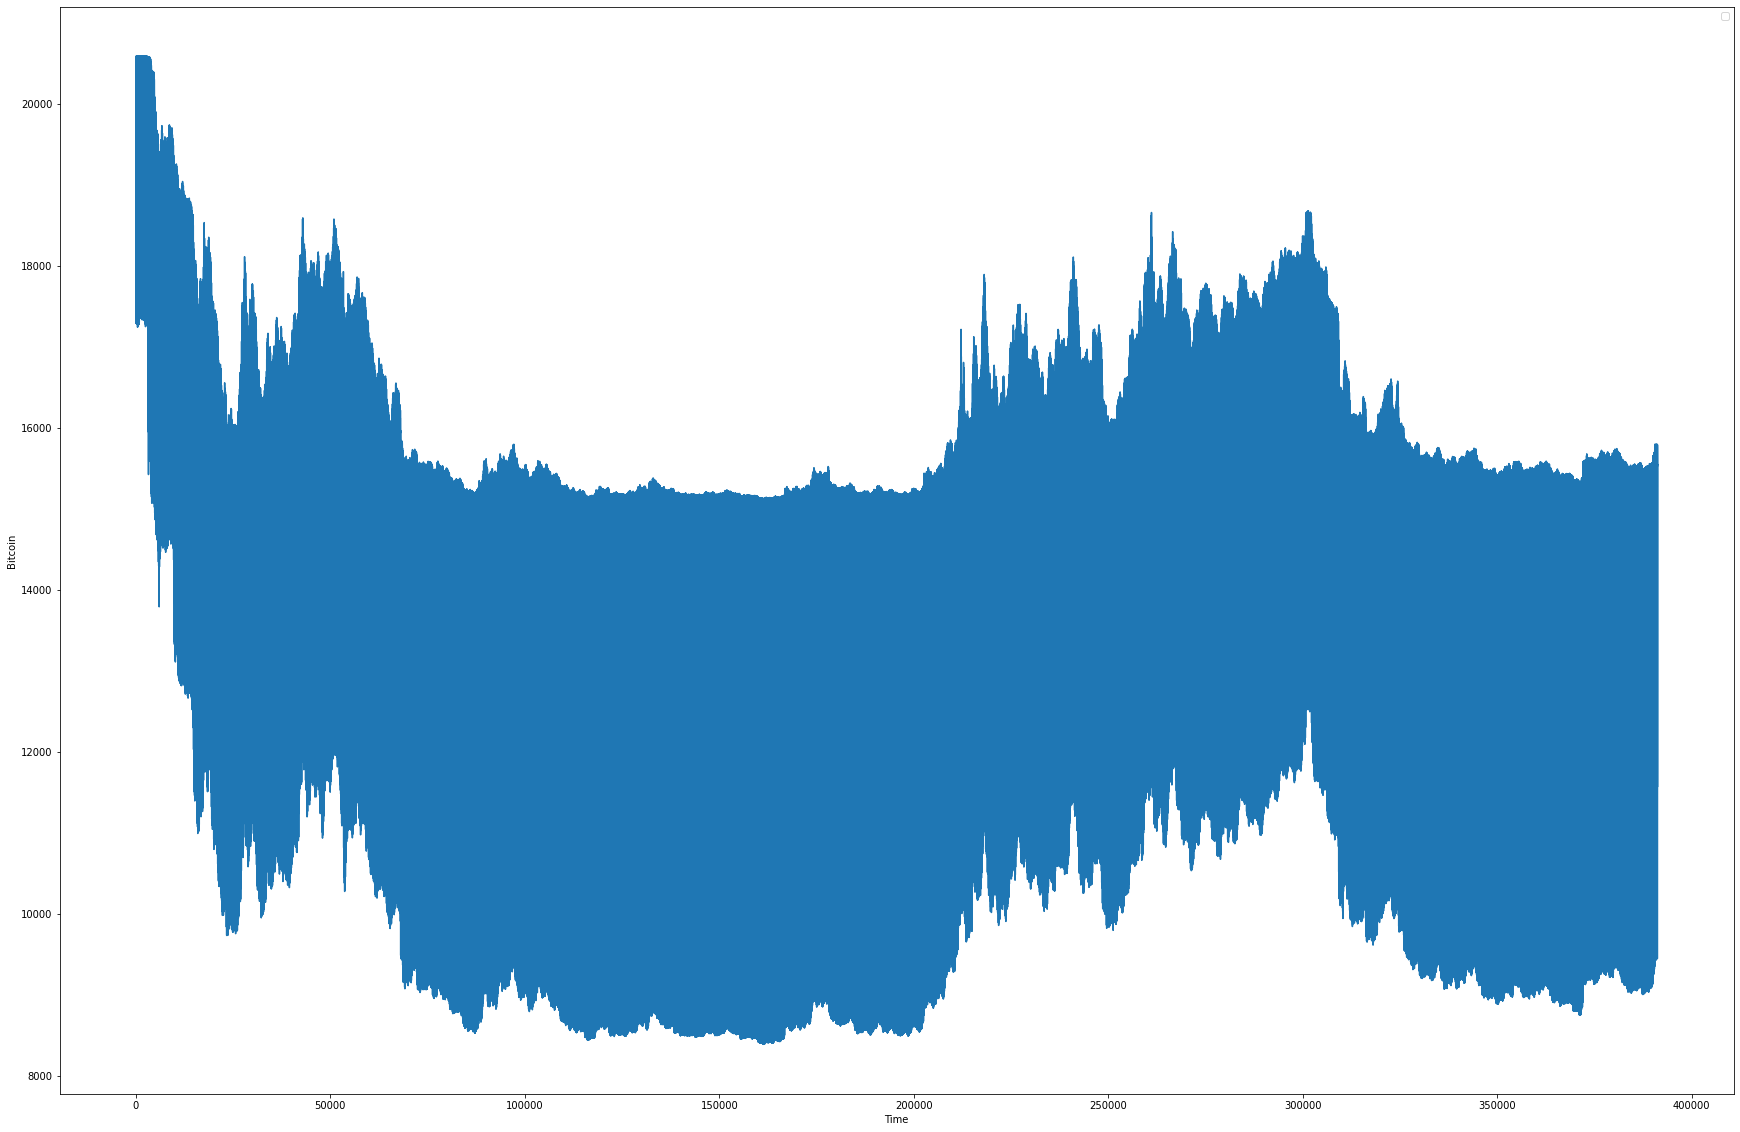

In [25]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(30,20))

plt.plot(test_predictions.flatten())
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')


plt.show()

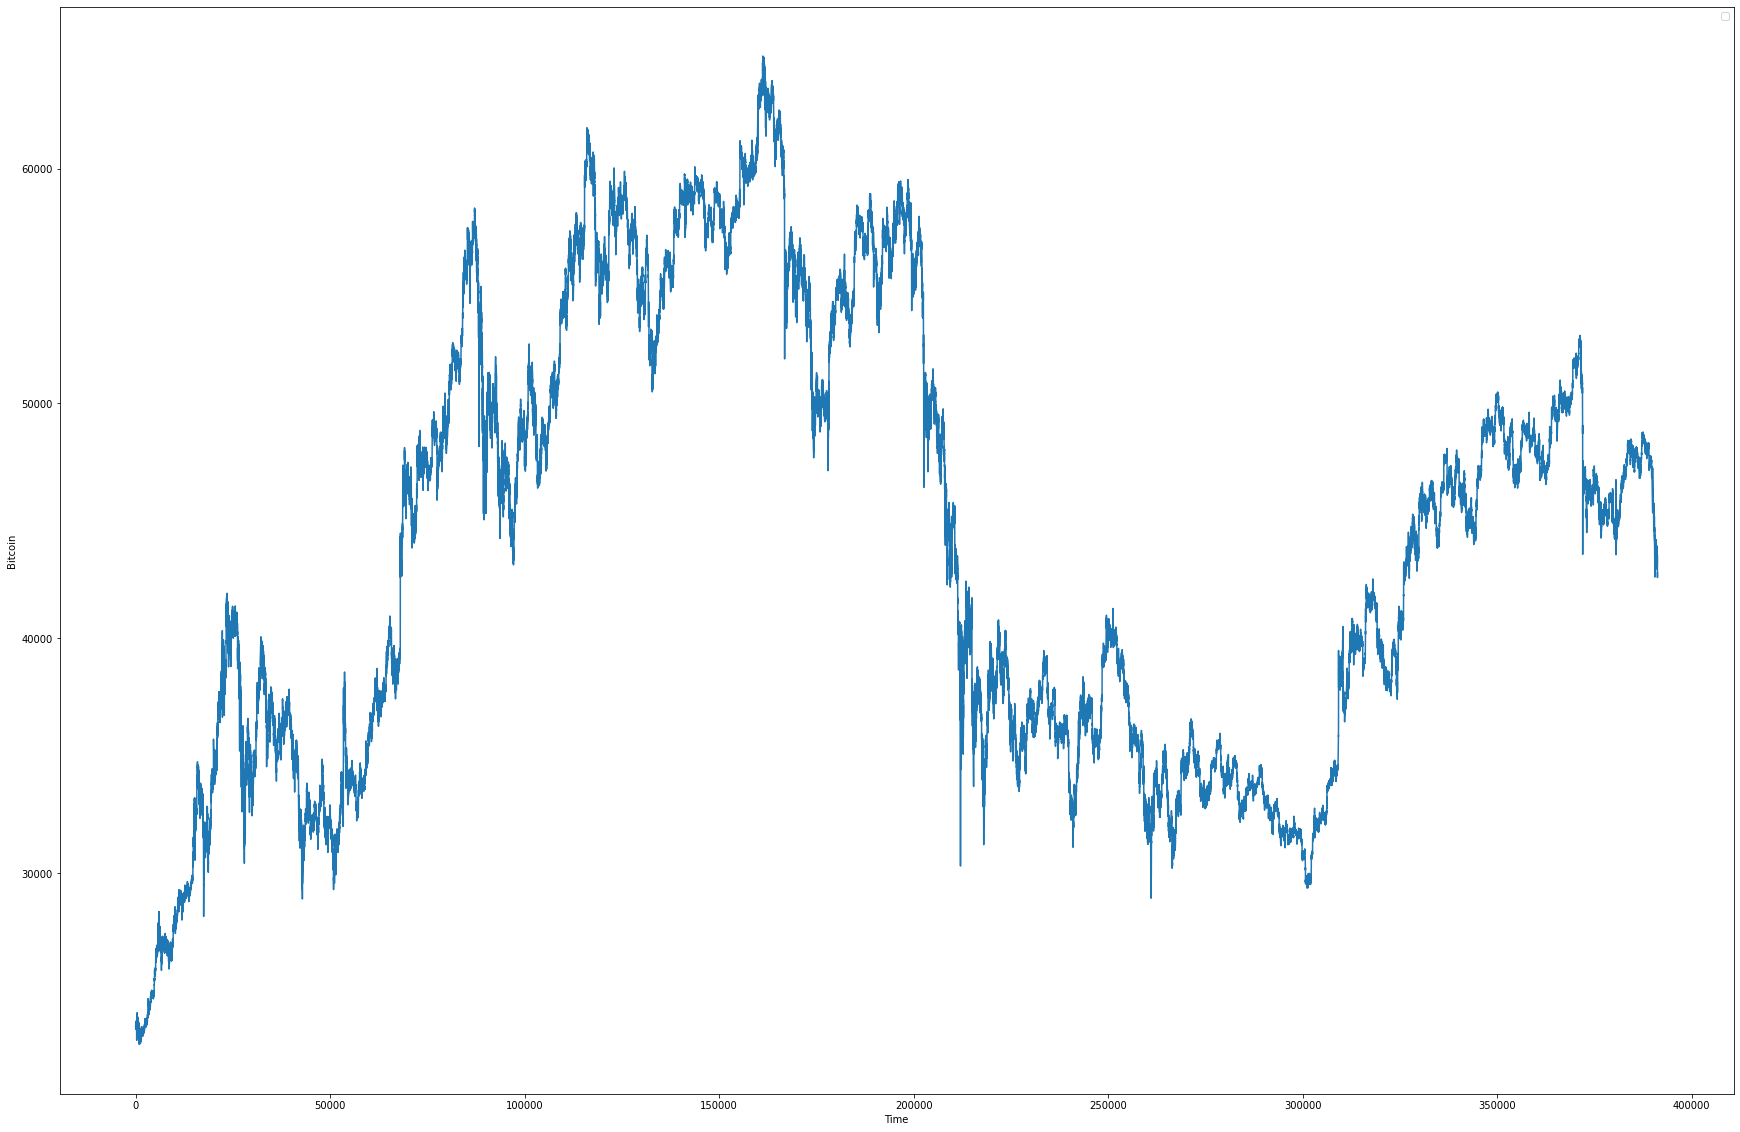

In [26]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(30,20))

plt.plot(test_batch_labels.flatten())
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')


plt.show()